<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/Final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**this notebook contains the following models: svm, svm+ RBF kernel, and gradient boosting**

In [1]:
import csv
import shutil
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2

**DOWNLOAD COUGHVID DATASET**








In [2]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
# https://zenodo.org/record/4048312/files/public_dataset.zip?download=1 (older version of ds)
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip


--2022-02-27 18:30:25--  https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>]   1.24G  25.4MB/s    in 49s     

2022-02-27 18:31:15 (26.0 MB/s) - ‘public_dataset.zip?download=1’ saved [1332806163/1332806163]



In [ ]:

'''#remove .ogg files  
for file in os.listdir('public_dataset'):
    if file.endswith(".ogg") :
        os.remove('public_dataset/'+file)
        
        name, file_extension=os.path.splitext(file)
        os.remove('public_dataset/'+name+'.json')
        '''
  

In [3]:
c=0
j=0
o=0
for file in os.listdir('public_dataset'):
    if file.endswith(".webm") :
        c+=1
        
    if file.endswith(".json") :
       j+=1
    if file.endswith(".ogg") :
       o+=1
print("no of .webm files  " +str(c))
print("no of .json files  "+str(j))
print("no of .ogg files   "+str(o))

no of .webm files  25985
no of .json files  27550
no of .ogg files   1565



**SELECT COVID SAMPLES FROM COUGHVID DATASET**


In [4]:
count=0
webm_count=0
covid_samples_count=0
reduced=0
bad=0

selected_filenames=[]
coughvid_webm_files=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        count+=1
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='COVID-19'):
                    covid_samples_count+=1

                    if 'expert_labels_1' in data:
                        if(data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_2' in data:
                        if(data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_3' in data:
                        if(data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    else:
                        reduced+=1
                        selected_filenames.append(path)
        if file.endswith(".webm"):
           coughvid_webm_files.append(file)


In [5]:
#print(selected_filenames)
print(len(selected_filenames))

438


In [6]:
print("Total Number of samples :",count)
print("\nTotal Number of COVID-19 samples with cough_detected score>0.9 :",covid_samples_count)
print("\nExpert labeled COVID-19 samples with quality good/ok OR not expert labelled :",reduced)

Total Number of samples : 27550

Total Number of COVID-19 samples with cough_detected score>0.9 : 499

Expert labeled COVID-19 samples with quality good/ok OR not expert labelled : 438


SAVE +VE SAMPLES

In [7]:
!mkdir coughvidpos


In [8]:

for i in selected_filenames:
  name=os.path.splitext(i)[0]
  if os.path.exists(name+'.webm'):
    filepath=name+'.webm'
    shutil.copy(filepath,'/content/coughvidpos')
  else:   
    filepath=name+'.ogg'
    shutil.move(filepath,'/content/coughvidpos')


In [9]:

len([file for file in os.listdir('/content/coughvidpos')])
  

438

SELECT HEALTHY SAMPLES FROM COUGHVID DATASET


In [10]:
!mkdir coughvidnegative

In [11]:
healthy_samples=0
reduced=0
paths=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='healthy'):
                    healthy_samples+=1

                    if 'expert_labels_1' in data:
                        if((data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_2' in data:
                        if((data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_3' in data:
                        if((data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    else:
                        reduced+=1
                        paths.append(path)
                        
    if reduced==2230:
        break

In [12]:
print("Number of healthy cough sound samples considered : ",reduced)

Number of healthy cough sound samples considered :  2230


In [13]:

cougvidnegative = '/content/coughvidnegative'
for i in paths:
    name=os.path.splitext(i)[0]
    if os.path.exists(name+'.webm'):
      filepath=name+'.webm'
      shutil.copy(filepath,cougvidnegative)
    else:   
     filepath=name+'.ogg'
     shutil.move(filepath,cougvidnegative)


In [14]:

len([file for file in os.listdir('/content/coughvidnegative')])
 


2230

In [15]:
!mkdir val train test
!mkdir COVID HEALTHY
!mkdir val/COVID 
!mkdir val/HEALTHY
!mkdir test/COVID 
!mkdir test/HEALTHY
!mkdir train/COVID 
!mkdir train/HEALTHY

In [17]:
import soundfile as sf
for filename in os.listdir('/content/coughvidpos'):
        samples, sr = librosa.load('/content/coughvidpos/'+filename, sr= 22050)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/COVID/'+audio_file+'.wav',samples,sr)
 

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [18]:
len([file for file in os.listdir('COVID')])

438

In [19]:

for filename in os.listdir('/content/coughvidnegative'):
        samples, sr = librosa.load('/content/coughvidnegative/'+filename, sr=sr)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/HEALTHY/'+audio_file+'.wav',samples,sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [20]:
len([file for file in os.listdir('HEALTHY')])

2230

In [21]:
#we don't need these directories antmore, free up space 
shutil.rmtree('/content/coughvidpos')
shutil.rmtree('/content/coughvidnegative')
shutil.rmtree('/content/public_dataset')

**COUGHVID DATA AUGMENTATION**

In [22]:
!pip install audiomentations

     |████████████████████████████████| 60 kB 3.5 MB/s 


In [23]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf

In [24]:
!mkdir augmented_covid_data

In [25]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COVID'
augmented_data= '/content/augmented_covid_data'
for audio_file in os.listdir(sets):
        samples, sr = librosa.load(sets+'/'+audio_file)
        augmented_sample = augment(samples=samples, sample_rate=sr)
        sf.write(augmented_data+'/aug_'+audio_file, augmented_sample, sr)

In [26]:
#number of  augmented covid samples
len([file for file in os.listdir('/content/augmented_covid_data')])

438

**COSWARA DATASET**


In [27]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 43.36 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [28]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200814
20200415
20200911
20201012
20210714
20210419
20200820
20210830
20220224
20200604
20200525
20201221
20210406
20200803
20200505
20200413
20200502
20200824
20200707
20210930
20210914
20200930
20210603
20200418
20210816
20210507
20210618
20201130
20210206
20201031
20200919
20200419
20200504
20220116
20200417
20200430
20200901
20210630
20210426
20210523
20200720
20200424
20200416


In [29]:
healthy_count=0
covid_pos_count=0
with open('/content/Coswara-Data/combined_data.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        COVID_STATUS=row[2]
        if(COVID_STATUS=='healthy' or COVID_STATUS=='resp_illness_not_identified' or COVID_STATUS=='no_resp_illness_exposed' or COVID_STATUS== 'recovered_full'):
            healthy_count+=1
        elif(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
            covid_pos_count+=1
    
print("Healthy => ",healthy_count," Covid => ",covid_pos_count)

Healthy =>  1984  Covid =>  681


In [30]:
from operator import length_hint
names   = ['ID','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')
  temp        = temp[['id','covid_status','DIR']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:29<00:00, 93.64it/s] 


,ID,STATUS,DIR,DataSet
0,3FD9salx6KQf114qJSSvW74Ffi63,healthy,/content/Coswara-Data/20200814/3FD9salx6KQf114...,coswara
0,j31umQI0FpRQTOBIkTlKlGlPhF03,resp_illness_not_identified,/content/Coswara-Data/20200814/j31umQI0FpRQTOB...,coswara
0,uHyBfROrEHMS9M9ukCOB7sCNH9I2,no_resp_illness_exposed,/content/Coswara-Data/20200814/uHyBfROrEHMS9M9...,coswara
0,zVkoMlwOqwXzjsgyGs99OoU10J92,healthy,/content/Coswara-Data/20200814/zVkoMlwOqwXzjsg...,coswara
0,05bieNLXPuaIWEVaX81EkbbjVrh1,healthy,/content/Coswara-Data/20200814/05bieNLXPuaIWEV...,coswara


In [31]:
CosData1['STATUS'].unique()

array(['healthy', 'resp_illness_not_identified',
       'no_resp_illness_exposed', 'positive_mild', 'recovered_full',
       'positive_moderate', 'positive_asymp', 'under_validation'],
      dtype=object)

In [32]:
!mkdir coswara_COVID

In [33]:
for index, row in CosData1.iterrows():
  COVID_STATUS=row[1]  
  if(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
     try:
      shutil.copy(row[2],'/content/coswara_COVID/'+row[0]+'-s-'+'.wav')
      
     except:
      
        print("file not found")

In [34]:
#this a stupid way to resample, fixing it later
!mkdir COSWARA_COVID_SAMPLES
for filename in os.listdir('/content/coswara_COVID'):
   try:
        samples, sr = librosa.load('/content/coswara_COVID/'+filename, sr=sr)
        sf.write ('/content/COSWARA_COVID_SAMPLES/'+filename,samples,sr)
   except:
    print("file too small")
shutil.rmtree('/content/coswara_COVID')

file too small
file too small
file too small


In [38]:
len([file for file in os.listdir('/content/coswara_COVID')])

FileNotFoundError: ignored

In [35]:

for i in os.listdir('/content/COSWARA_COVID_SAMPLES'):
  print( librosa.get_samplerate('/content/COSWARA_COVID_SAMPLES/' +i))

22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
2205

**COSWARA DATA AUGMENTATION**

In [36]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COSWARA_COVID_SAMPLES'
for audio_file in os.listdir(sets):
  try:
     samples, sr = librosa.load(sets+'/'+audio_file)
     augmented_sample = augment(samples=samples, sample_rate=sr)
     sf.write('/content/augmented_covid_data'+'/coswara_aug_'+audio_file, augmented_sample, sr)

  except:
    print("\n File can't open")

In [37]:
len([file for file in os.listdir('/content/augmented_covid_data')])

1116

**move coswara covid files to COVID directory** 

In [38]:
for file in os.listdir('/content/COSWARA_COVID_SAMPLES'):
    shutil.move('/content/COSWARA_COVID_SAMPLES/'+ file, '/content/COVID/')

In [39]:
len([file for file in os.listdir('/content/COVID')])

1116

In [40]:
len([file for file in os.listdir('HEALTHY')])

2230

In [41]:
#total no of covid samples 
len([file for file in os.listdir('/content/COVID')])+len([file for file in os.listdir('/content/augmented_covid_data')])

2232

**SPLIT 80 , 10 , 10 for train, val,test**

In [42]:
num=0
for file in os.listdir('COVID'):
    num+=1
    if num<=446:
        shutil.copy('/content/COVID/'+file,'/content/test/COVID/'+file)
    # elif num<=446:
     #   shutil.copy('/content/COVID/'+file,'/content/val/COVID/'+file)
    else:
        shutil.copy('/content/COVID/'+file,'/content/train/COVID/'+file)
        
for file in os.listdir('/content/augmented_covid_data'):
        shutil.copy('/content/augmented_covid_data/'+file,'/content/train/COVID/'+file)

In [43]:
num=0
for file in os.listdir('HEALTHY'):
    num+=1
    if num<=446:
        shutil.copy('/content/HEALTHY/'+file,'/content/test/HEALTHY/'+file)
    # elif num<= 446:
       # shutil.copy('/content/HEALTHY/'+file,'/content/val/HEALTHY/'+file)
    else:
        shutil.copy('/content/HEALTHY/'+file,'/content/train/HEALTHY/'+file)

In [44]:
#remove coswara directory to free up some space
shutil.rmtree('/content/Coswara-Data')

In [45]:

print(" train/COVID =>",len([file for file in os.listdir('train/COVID')]))
print(" test/COVID =>",len([file for file in os.listdir('test/COVID')]))
#print(" val/COVID =>",len([file for file in os.listdir('val/COVID')]))


print(" train/healthy =>",len([file for file in os.listdir('train/HEALTHY')]))
print(" test/healthy =>",len([file for file in os.listdir('test/HEALTHY')]))
#print(" val/healthy =>",len([file for file in os.listdir('val/HEALTHY')]))


 train/COVID => 1786
 test/COVID => 446
 train/healthy => 1784
 test/healthy => 446


In [46]:
!pip install pyAudioAnalysis

     |████████████████████████████████| 41.3 MB 1.2 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=4395a4acf8182365d87380cf68d7c133ff6af392d11122c27e81faa054098c74
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [47]:
!pip install eyed3

     |████████████████████████████████| 245 kB 5.2 MB/s 
     |████████████████████████████████| 242 kB 34.7 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 5.5 which is incompatible.


In [48]:
!pip install pydub

In [49]:
from pyAudioAnalysis import audioTrainTest as aT

\



---


---












**KNN MODEL**


---


---




In [50]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "knn", "knn_model", False)

Analyzing file 1 of 1786: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 1786: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 3 of 1786: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 4 of 1786: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 5 of 1786: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 6 of 1786: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 7 of 1786: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 8 of 1786: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 9 of 1786: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 10 of 1786: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 11 of 1786: train/COVID/0837bd59-09c5-4098-afe3-4bcbfb0fb0e2.wav
Analyzing file 12 of 1786: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 13 of 1786: train/COVID/08tlSbvXpAggZavIGW99

Testing KNN

---



In [51]:

cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "knn_model", "knn","COVID")

[[ 94 352]
 [ 34 412]]
[0.21076233183856502, 0.9237668161434978] [0.734375, 0.5392670157068062] [0.3275261324041812, 0.6809917355371901] 0.5042589339706857 0.5672645739910314


Text(60.0, 0.5, 'Truth value')

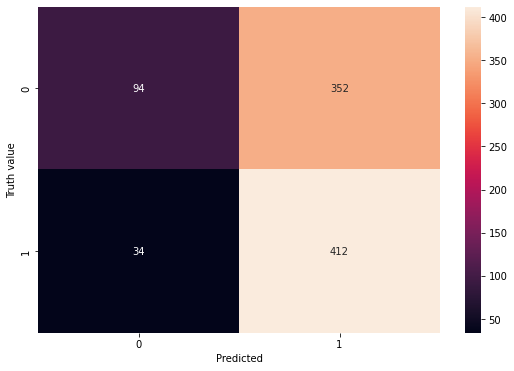

In [53]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [54]:
acc=(94+412)/(94+412+34+352)

print(" Accuracy : {0:.2f}".format(acc*100))


 Accuracy : 56.73


\



---


---












**Svm-Rbf Model**


---


---




In [55]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm_rbf", "svm_rbf_model", False)

Analyzing file 1 of 1786: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 1786: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 3 of 1786: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 4 of 1786: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 5 of 1786: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 6 of 1786: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 7 of 1786: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 8 of 1786: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 9 of 1786: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 10 of 1786: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 11 of 1786: train/COVID/0837bd59-09c5-4098-afe3-4bcbfb0fb0e2.wav
Analyzing file 12 of 1786: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 13 of 1786: train/COVID/08tlSbvXpAggZavIGW99

In [57]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "svm_rbf_model", "svm","COVID")

[[254 192]
 [ 68 378]]
[0.5695067264573991, 0.8475336322869955] [0.7888198757763976, 0.6631578947368421] [0.6614583333333334, 0.7440944881889765] 0.7027764107611549 0.7085201793721974


Text(60.0, 0.5, 'Truth value')

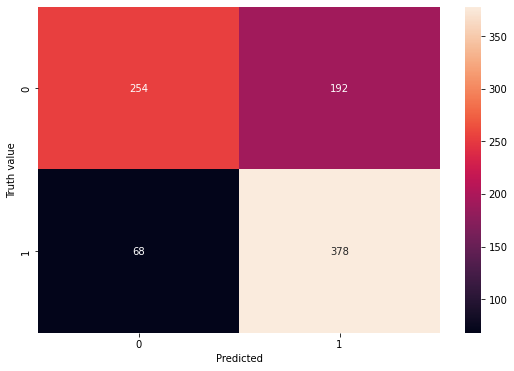

In [58]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [59]:

acc=(254+378)/(254+378+192+68)

print(" Accuracy : {0:.2f}".format(acc*100))


 Accuracy : 70.85


\



---


---












**Gradiant Boosting Model**


---


---




In [60]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "gradientboosting", "gb_model", False)

Analyzing file 1 of 1786: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 1786: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 3 of 1786: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 4 of 1786: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 5 of 1786: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 6 of 1786: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 7 of 1786: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 8 of 1786: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 9 of 1786: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 10 of 1786: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 11 of 1786: train/COVID/0837bd59-09c5-4098-afe3-4bcbfb0fb0e2.wav
Analyzing file 12 of 1786: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 13 of 1786: train/COVID/08tlSbvXpAggZavIGW99

In [61]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "gb_model", "gradientboosting","COVID")

[[248 198]
 [ 63 383]]
[0.5560538116591929, 0.8587443946188341] [0.797427652733119, 0.6592082616179001] [0.655217965653897, 0.7458617332035054] 0.7005398494287012 0.7073991031390134


Text(60.0, 0.5, 'Truth value')

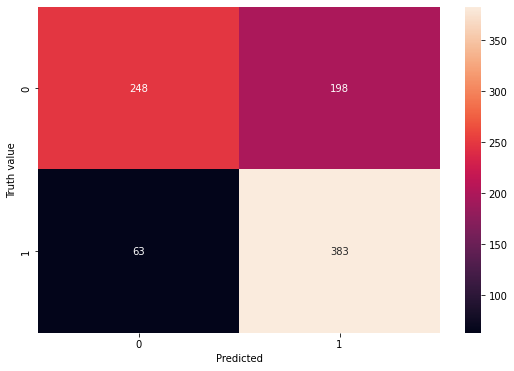

In [62]:
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [63]:
acc=(248+383)/(248+383+198+63)

print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 70.74


\



---


---












**Random Forest Model**


---


---




In [64]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "randomforest", "rf_model", False)

Analyzing file 1 of 1786: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 1786: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 3 of 1786: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 4 of 1786: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 5 of 1786: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 6 of 1786: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 7 of 1786: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 8 of 1786: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 9 of 1786: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 10 of 1786: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 11 of 1786: train/COVID/0837bd59-09c5-4098-afe3-4bcbfb0fb0e2.wav
Analyzing file 12 of 1786: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 13 of 1786: train/COVID/08tlSbvXpAggZavIGW99

In [65]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "rf_model", "randomforest","COVID")

[[240 206]
 [ 61 385]]
[0.5381165919282511, 0.8632286995515696] [0.7973421926910299, 0.6514382402707276] [0.642570281124498, 0.742526518804243] 0.6925483999643705 0.7006726457399103


Text(60.0, 0.5, 'Truth value')

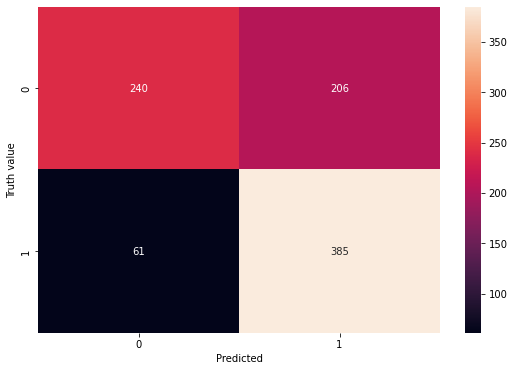

In [66]:
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [67]:
acc=(240+385)/(240+385+61+206)

print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 70.07
